In [233]:
import pandas as pd
from Historic_Crypto import HistoricalData  # Uses coinbase pro API
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pystable

# Get Data

Pull from Coinbase API

In [234]:
# df = HistoricalData('ETH-USD', 300,'2016-06-01-00-00').retrieve_data()
# df.to_csv('csv/ETH-USD-300-20160601-20220824.csv')

Or read from CSV

In [235]:
df = pd.read_csv('../csv/ETH-USD-300-20160601-20220824.csv', index_col=0)

In [236]:
df.head()

,low,high,open,close,volume
time,,,,,
2016-06-01 00:00:00,14.15,14.18,14.15,14.18,35.206821
2016-06-01 00:05:00,14.16,14.16,14.16,14.16,36.402093
2016-06-01 00:10:00,14.00,14.12,14.12,14.11,40.854990
2016-06-01 00:20:00,13.98,14.10,14.10,13.98,244.776964
2016-06-01 00:30:00,13.87,14.00,14.00,13.87,155.823036


In [237]:
df.tail()

,low,high,open,close,volume
time,,,,,
2022-08-24 09:15:00,1636.89,1640.00,1639.25,1638.76,643.336227
2022-08-24 09:20:00,1637.70,1642.87,1638.68,1638.30,1077.099748
2022-08-24 09:25:00,1635.55,1638.51,1638.22,1637.99,812.387659
2022-08-24 09:30:00,1634.14,1638.37,1637.97,1634.68,805.469833
2022-08-24 09:35:00,1632.74,1636.22,1634.65,1634.14,1098.373920


# Data Sanity Checks

In [238]:
# Make time a column instead of index

df.reset_index(inplace=True)
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,low,high,open,close,volume
0,2016-06-01 00:00:00,14.15,14.18,14.15,14.18,35.206821
1,2016-06-01 00:05:00,14.16,14.16,14.16,14.16,36.402093
2,2016-06-01 00:10:00,14.00,14.12,14.12,14.11,40.854990
3,2016-06-01 00:20:00,13.98,14.10,14.10,13.98,244.776964
4,2016-06-01 00:30:00,13.87,14.00,14.00,13.87,155.823036


In [239]:
# Check if there is data at every 5 min interval

lag_diff = df.time - df.time.shift(1)
print(lag_diff.min())
print(lag_diff.max())

0 days 00:05:00
0 days 05:50:00


In [240]:
# Pull cases where difference is greater than 10 mins.
# 10 mins cuz shorter TWAP on ETHUSD is 10 mins.

lag_diff[lag_diff > datetime.timedelta(minutes=10)].sort_values()

57009    0 days 00:15:00
5194     0 days 00:15:00
56996    0 days 00:15:00
56991    0 days 00:15:00
5198     0 days 00:15:00
               ...      
626      0 days 03:05:00
164929   0 days 03:10:00
81220    0 days 03:55:00
43772    0 days 05:10:00
68079    0 days 05:50:00
Name: time, Length: 1853, dtype: timedelta64[ns]

In [241]:
(1853/df.shape[0]) * 100

# 0.28% of the data is affected

0.2876337659999193

In [242]:
# Check some problematic rows manually

df.iloc[68077:68080]

,time,low,high,open,close,volume
68077,2017-02-28 19:35:00,16.22,16.41,16.40,16.24,838.477119
68078,2017-02-28 19:40:00,16.16,16.40,16.24,16.40,347.705348
68079,2017-03-01 01:30:00,15.75,15.83,15.75,15.83,832.450212


In [243]:
# Create 2 new columns
# lag_diff_time: seconds difference between current and previous row
# lag_diff_price: percentage difference in close price between current and previous row

df['lag_diff_time'] = (df.time - df.time.shift(1)).dt.seconds
df['lag_diff_price'] = (abs(df.close - df.close.shift(1))/df.close.shift(1))*100
df.head()

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price
0,2016-06-01 00:00:00,14.15,14.18,14.15,14.18,35.206821,NaN,NaN
1,2016-06-01 00:05:00,14.16,14.16,14.16,14.16,36.402093,300.0,0.141044
2,2016-06-01 00:10:00,14.00,14.12,14.12,14.11,40.854990,300.0,0.353107
3,2016-06-01 00:20:00,13.98,14.10,14.10,13.98,244.776964,600.0,0.921332
4,2016-06-01 00:30:00,13.87,14.00,14.00,13.87,155.823036,600.0,0.786838


In [244]:
# Get max price diff % for each lag_diff_time

df_max = df[['lag_diff_time', 'lag_diff_price']]\
    .groupby('lag_diff_time').max()
df_max = df_max.sort_values(by='lag_diff_price', ascending=False).reset_index()
df_max

,lag_diff_time,lag_diff_price
0,300.0,16.711916
1,600.0,7.777778
2,900.0,5.146036
3,1200.0,3.781095
4,21000.0,3.475610
5,1500.0,3.383793
6,2400.0,3.319080
7,2700.0,3.247294
8,3900.0,3.196347
9,3600.0,3.120760


In [245]:
# Top lag_diff_price values look bad. Check if the close price around those
# values justifies that kind of percentage movement

df_max.merge(df,on=['lag_diff_time', 'lag_diff_price'], how='inner')\
    [['time', 'lag_diff_time', 'lag_diff_price', 'close']]

# Results show that the worst lag_diff_prices are seen at low prices. Mostly sub 100.
# So the high percentages don't look bad

,time,lag_diff_time,lag_diff_price,close
0,2021-05-19 12:55:00,300.0,16.711916,2334.25
1,2016-06-20 12:15:00,600.0,7.777778,11.64
2,2016-06-01 05:35:00,900.0,5.146036,13.64
3,2016-07-05 10:20:00,1200.0,3.781095,10.43
4,2017-03-01 01:30:00,21000.0,3.475610,15.83
5,2016-06-20 10:55:00,1500.0,3.383793,10.85
6,2017-07-18 21:25:00,2400.0,3.319080,237.40
7,2016-07-15 08:00:00,2700.0,3.247294,12.40
8,2016-07-10 09:35:00,3900.0,3.196347,11.30
9,2016-06-10 11:55:00,3600.0,3.120760,14.28


In [246]:
# Find out 90th percentile of lag_diff_price

abs_price_delta = np.array(df.lag_diff_price[1:])
np.percentile(abs_price_delta, 90)

0.472652218782254

In [247]:
# Check if lag_diff_price is every greater than 90th percentile when price is high

df[(df.lag_diff_price >= 0.472652218782254)
    & (df.lag_diff_time > 600) 
    & (df.close > 500)]

# Just 4 cases; not bad

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price
150276,2017-12-12 07:20:00,520.00,533.42,533.41,524.21,4038.008042,5700.0,1.724752
153281,2017-12-22 18:15:00,606.28,642.47,642.47,625.70,6499.746020,1800.0,2.640546
164929,2018-02-01 08:05:00,1122.00,1129.99,1129.99,1122.01,428.653709,11400.0,0.707080
193098,2018-05-10 05:10:00,751.99,763.02,751.99,763.02,1612.600303,6300.0,1.503219


# Convert data to 10 minute TWAP

In [248]:
# Remove every alternate row to get to 10 min periodicity

twap_base = df.iloc[[i for i in range(0, len(df), 2)],]\
    .reset_index()\
    .drop('index', axis=1)
twap_base.head(10)

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price
0,2016-06-01 00:00:00,14.15,14.18,14.15,14.18,35.206821,NaN,NaN
1,2016-06-01 00:10:00,14.00,14.12,14.12,14.11,40.854990,300.0,0.353107
2,2016-06-01 00:30:00,13.87,14.00,14.00,13.87,155.823036,600.0,0.786838
3,2016-06-01 01:05:00,13.88,14.10,13.99,13.88,14.000000,1800.0,0.715308
4,2016-06-01 01:20:00,14.09,14.09,14.09,14.09,3.502622,600.0,0.931232
5,2016-06-01 01:30:00,14.07,14.09,14.07,14.09,7.084521,300.0,1.586157
6,2016-06-01 01:40:00,13.96,14.11,14.11,13.96,24.740910,300.0,0.992908
7,2016-06-01 01:50:00,13.95,14.14,13.95,13.95,7.070983,300.0,1.063830
8,2016-06-01 02:30:00,13.94,13.94,13.94,13.94,0.740000,300.0,1.484099
9,2016-06-01 02:40:00,14.24,14.34,14.24,14.34,699.314405,300.0,2.355460


#### Data quality checks on 10 min data

In [249]:
# Create 2 new columns
# lag_diff_time: seconds difference between current and previous row
# lag_diff_price: percentage difference in close price between current and previous row

twap_base['lag_diff_time'] = (twap_base.time - twap_base.time.shift(1)).dt.seconds
twap_base['lag_diff_price'] = (abs(twap_base.close - twap_base.close.shift(1))/twap_base.close.shift(1))*100
twap_base.head()

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price
0,2016-06-01 00:00:00,14.15,14.18,14.15,14.18,35.206821,NaN,NaN
1,2016-06-01 00:10:00,14.00,14.12,14.12,14.11,40.854990,600.0,0.493653
2,2016-06-01 00:30:00,13.87,14.00,14.00,13.87,155.823036,1200.0,1.700921
3,2016-06-01 01:05:00,13.88,14.10,13.99,13.88,14.000000,2100.0,0.072098
4,2016-06-01 01:20:00,14.09,14.09,14.09,14.09,3.502622,900.0,1.512968


In [250]:
# Pull cases where difference is greater than 10 mins.
# 10 mins cuz shorter TWAP on ETHUSD is 10 mins.

lag_diff[lag_diff > datetime.timedelta(minutes=10)].sort_values()

# Still 1853 cases. Same as `df`. Makes sense

57009    0 days 00:15:00
5194     0 days 00:15:00
56996    0 days 00:15:00
56991    0 days 00:15:00
5198     0 days 00:15:00
               ...      
626      0 days 03:05:00
164929   0 days 03:10:00
81220    0 days 03:55:00
43772    0 days 05:10:00
68079    0 days 05:50:00
Name: time, Length: 1853, dtype: timedelta64[ns]

In [251]:
# Get max price diff % for each lag_diff_time

twap_max = twap_base[['lag_diff_time', 'lag_diff_price']]\
    .groupby('lag_diff_time').max()
twap_max = twap_max.sort_values(by='lag_diff_price', ascending=False).reset_index()
twap_max

,lag_diff_time,lag_diff_price
0,600.0,21.943000
1,900.0,9.011858
2,1200.0,6.610879
3,1800.0,4.946237
4,1500.0,3.920308
5,2700.0,3.712769
6,3000.0,3.631285
7,21300.0,3.475610
8,3600.0,3.474903
9,5100.0,3.196347


#### Convert to twap

In [252]:
twap_base['shift_close'] = twap_base.close.shift(1)
twap_base['twap'] = twap_base[['close', 'shift_close']].mean(axis=1)
twap_base

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price,shift_close,twap
0,2016-06-01 00:00:00,14.15,14.18,14.15,14.18,35.206821,NaN,NaN,NaN,14.180
1,2016-06-01 00:10:00,14.00,14.12,14.12,14.11,40.854990,600.0,0.493653,14.18,14.145
2,2016-06-01 00:30:00,13.87,14.00,14.00,13.87,155.823036,1200.0,1.700921,14.11,13.990
3,2016-06-01 01:05:00,13.88,14.10,13.99,13.88,14.000000,2100.0,0.072098,13.87,13.875
4,2016-06-01 01:20:00,14.09,14.09,14.09,14.09,3.502622,900.0,1.512968,13.88,13.985
...,...,...,...,...,...,...,...,...,...,...
322106,2022-08-24 08:50:00,1636.04,1639.61,1639.41,1638.71,501.752350,600.0,0.106294,1636.97,1637.840
322107,2022-08-24 09:00:00,1633.36,1639.96,1634.31,1637.14,1369.311727,600.0,0.095807,1638.71,1637.925
322108,2022-08-24 09:10:00,1636.43,1641.29,1638.87,1639.42,657.342569,600.0,0.139267,1637.14,1638.280
322109,2022-08-24 09:20:00,1637.70,1642.87,1638.68,1638.30,1077.099748,600.0,0.068317,1639.42,1638.860


# Check pystable parameters
also compare against benchmark dataset: data-1625069716_weth-usdc-twap.csv (data used in risk scripts)

In [253]:
def gaussian():
    return pystable.create(alpha=2.0, beta=0.0, mu=0.0,
                           sigma=1.0, parameterization=1)

In [254]:
# Check distribution params of benchmark dataset

p = pd.read_csv('../csv/data-1625069716_weth-usdc-twap.csv')['twap'].to_numpy()
log_close = [np.log(p[i]/p[i-1]) for i in range(1, len(p))]

dst_bench = gaussian()  # use gaussian as init dist to fit from
pystable.fit(dst_bench, log_close, len(log_close))
print(
    f'''
    fit params: alpha: {dst_bench.contents.alpha}, beta: {dst_bench.contents.beta},
    mu: {dst_bench.contents.mu_1}, sigma: {dst_bench.contents.sigma}
    '''
)


    fit params: alpha: 1.43149831092789, beta: -0.022462055264132277,
    mu: -1.1692906779177139e-05, sigma: 0.0015035528077298288
    


In [255]:
# First and last date of benchmark dataset.
# Later check the distribution params of twap_base for this date range

benchmark = pd.read_csv('../csv/data-1625069716_weth-usdc-twap.csv')
print('fist date:', benchmark.iloc[0, 1])
print('last date:', benchmark.iloc[len(benchmark)-1, 1])

fist date: 1618779052.0
last date: 1625069398.0


In [256]:
# Distribution params of twap_base

p = twap_base.twap.to_numpy()
log_close = [np.log(p[i]/p[i-1]) for i in range(1, len(p))]

dst = gaussian()  # use gaussian as init dist to fit from
pystable.fit(dst, log_close, len(log_close))
print(
    f'''
    fit params: alpha: {dst.contents.alpha}, beta: {dst.contents.beta},
    mu: {dst.contents.mu_1}, sigma: {dst.contents.sigma}
    '''
)


    fit params: alpha: 1.342649241329454, beta: 0.022417174265511,
    mu: 3.847955904581722e-05, sigma: 0.0012669630012203642
    


In [257]:
# Distribution params of twap_base between april 18 '21 and june 30 '21

p = twap_base[(twap_base['time'] >= '2021-04-18 20:50:00')
            & (twap_base['time'] <= '2021-06-30 16:09:00')]['twap'].to_numpy()
log_close = [np.log(p[i]/p[i-1]) for i in range(1, len(p))]

dst_comp = gaussian()  # use gaussian as init dist to fit from
pystable.fit(dst_comp, log_close, len(log_close))
print(
    f'''
    fit params: alpha: {dst_comp.contents.alpha}, beta: {dst_comp.contents.beta},
    mu: {dst_comp.contents.mu_1}, sigma: {dst_comp.contents.sigma}
    '''
)


    fit params: alpha: 1.5179091469857815, beta: 0.009270148048828836,
    mu: 1.7108851972357032e-05, sigma: 0.0023263642381387345
    


Parameters for all 3 datasets are different. Surprising that they are different for benchmark and comparison data too since they're both ETHUSD twaps over the same dates.


Compare benchmark and comparison TWAPs:

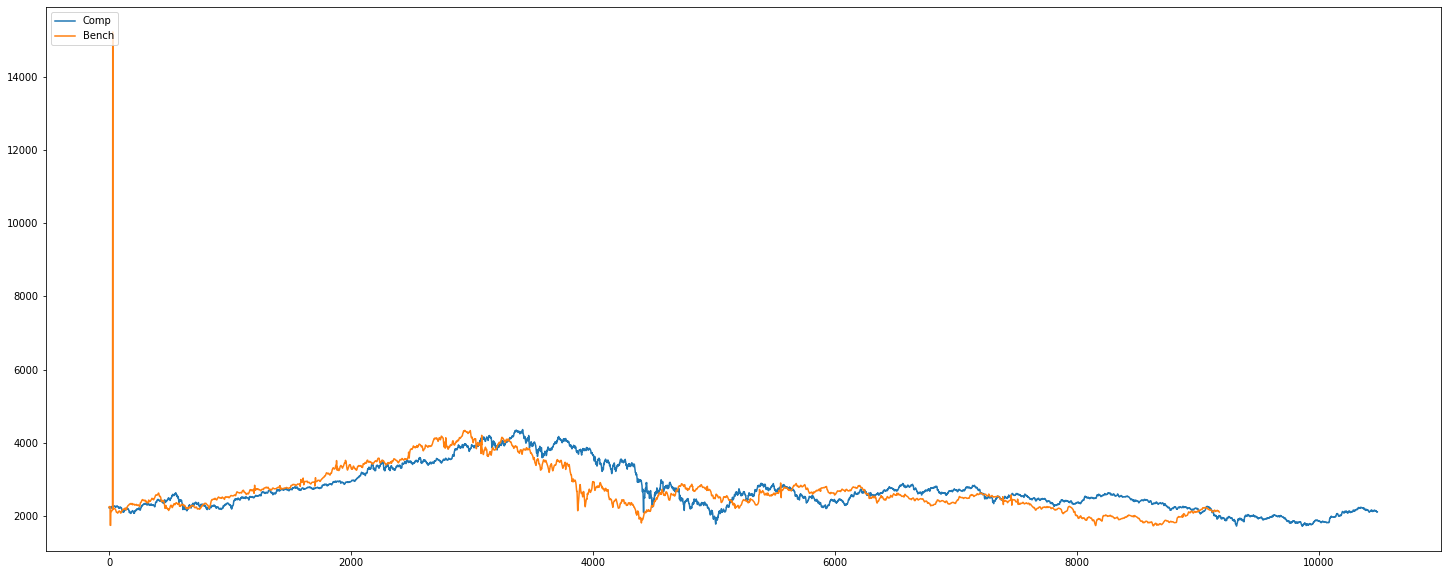

In [268]:
comp_p = list(twap_base[(twap_base['time'] >= '2021-04-18 20:50:00')
            & (twap_base['time'] <= '2021-06-30 16:09:00')]['twap'])

bench_p = list(pd.read_csv('../csv/data-1625069716_weth-usdc-twap.csv')['twap'])

plt.figure(figsize=(25,10))
plt.plot([i for i in range(len(comp_p))], comp_p, label='Comp')
plt.plot([i for i in range(len(bench_p))], [i/1000000 for i in bench_p], label='Bench')
plt.legend(loc='upper left')
plt.show()

# There's significant difference in these TWAPs

In [275]:
# And benchmark dataset has some garbage spikes
[i for i in bench_p if i > 5000000000]

[13305892848.0, 15222897497.0]

In [278]:
# Also benchmark df doesn't even have an accurate 10 min TWAP
bench_df = pd.read_csv('../csv/data-1625069716_weth-usdc-twap.csv')
bench_df['time_diff'] = bench_df.timestamp - bench_df.timestamp.shift(1)
bench_df['time_diff'].mean()

685.446878064727

So, benchmark doesn't look like a reliable dataset. Which is expected because it was pulled from Sushi's ETH USD pool at a time when uniswap v3's more liquid pool existed.

Now, let's see if there are similarities in CDF plots

In [258]:
l = [i/100 for i in range(1, 100, 1)]
p_bench = pystable.q(dst_bench, l, len(l))
p = pystable.q(dst, l, len(l))
p_comp = pystable.q(dst_comp, l, len(l))

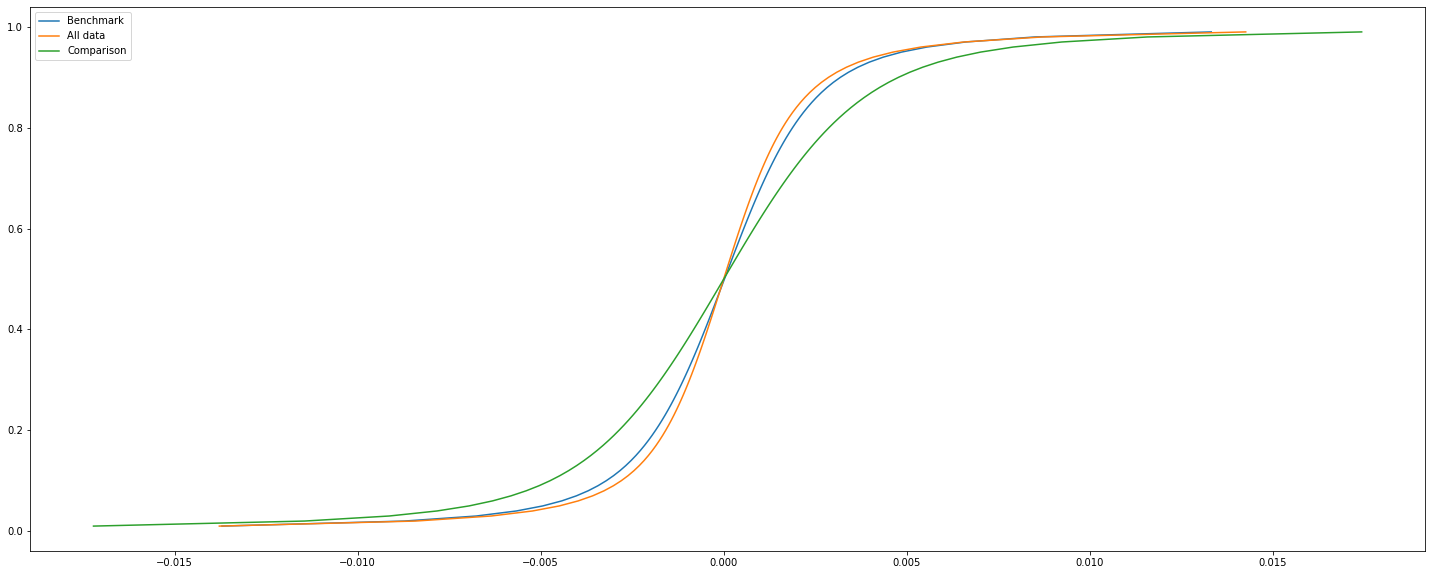

In [259]:
plt.figure(figsize=(25,10))
plt.plot(p_bench, l, label='Benchmark')
plt.plot(p, l, label='All data')
plt.plot(p_comp, l, label='Comparison')
plt.legend(loc='upper left')
plt.show()


Ignore "Benchmark" CDF (eventhough it's pretty similar to "All data" CDF) because of the unreliable data. "Comparison" data has fatter and longer tails compared to "All data". This is expected because comparison data consists of only ~2 months of very volatile price movements.

#### Conclusion: Instead of calibrating metrics over the entire price history, calibrate them over a volatile timeframe since that is a safer choice

In [280]:
# Save data
final_df = twap_base[(twap_base['time'] >= '2021-04-18 20:50:00')
            & (twap_base['time'] <= '2021-06-30 16:09:00')][['time', 'twap']]
final_df.to_csv('../csv/ETHUSD-600-20210401-20210630.csv')